In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:08, 43.61it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name
0,14562.0,1.0,0,1.0,00:00:01.344,58.0,9923.0,52.058824,34.430380,-10.588235,-0.000000,0,0,pass
1,14562.0,1.0,1,1.5,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,23,0,receival
2,14562.0,1.0,2,2.0,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,21,0,dribble
3,14562.0,1.0,3,2.0,00:00:02.969,58.0,9917.0,41.470588,34.430380,-15.882353,-14.632911,0,0,pass
4,14562.0,1.0,4,3.0,00:00:04.338,58.0,9924.0,25.588235,19.797468,-0.000000,-0.000000,23,0,receival


In [12]:
fs.play_left_to_right([acti])

Help on function play_left_to_right in module socceraction.atomic.features:

play_left_to_right(gamestates, home_team_id)



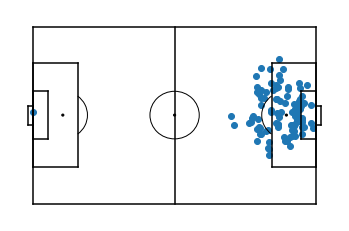

In [6]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

a = actions[actions.type_name == "shot"][:100]
ax = mps.field(show=False)
ax.scatter(a.x,a.y)
plt.show()

In [62]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
a = actions[actions.type_name == "shot"][:10000].copy()
#c = clus.KMeans(20).fit(a[["x","y"]])
gmm = mix.GaussianMixture(20).fit(a[["x","y"]])

CPU times: user 545 ms, sys: 306 ms, total: 851 ms
Wall time: 342 ms


In [ ]:
gmm.

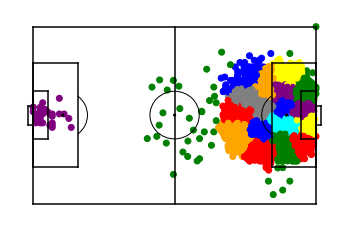

In [64]:
ax = mps.field(show=False)
colors = ["red","blue","green","purple","orange","cyan","yellow","grey"]*100
labels = gmm.predict(a[["x","y"]])
ax.scatter(a.x,a.y,color=[colors[l] for l in labels])
plt.show()

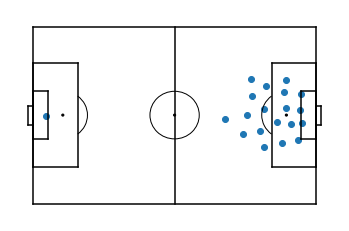

In [63]:
ax = mps.field(show=False)
#x = [cc[0] for cc in c.cluster_centers_]
#y = [cc[1] for cc in c.cluster_centers_]
x = [cc[0] for cc in gmm.means_]
y = [cc[1] for cc in gmm.means_]
ax.scatter(x,y)
plt.show()

In [70]:
import numpy

nbc = 20

a["cluster_id"] = c.labels_
nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(enumerate(a.groupby(["player_id"]))):
    probs = gmm.predict_proba(df[["x","y"]])
    playervector = probs.sum(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors

426it [00:01, 364.61it/s]


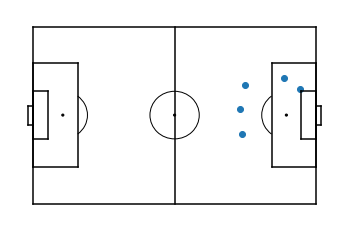

In [43]:
c_idx = vectors[3] > 0.1

x = np.array([cc[0] for cc in c.cluster_centers_])
y = np.array([cc[1] for cc in c.cluster_centers_])

ax = mps.field(show=False)
ax.scatter(x[c_idx],y[c_idx])
plt.show()

In [1]:
from sklearn.decomposition import NMF
model = NMF(4).fit(vectors)
model.components_

print(model.components_)

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    #ax.scatter(x[c_idx],y[c_idx],s=c_idx)
    ax.scatter(x,y,s=100*component)
    plt.show()

NameError: name 'vectors' is not defined